Config: {'fs': 20000000, 'num_samples': 200000, 'duration_s': 0.01, 'fc_global': 98000000, 'noise_floor_db': -88.0, 'num_stations': 15, 'min_sep_hz': 250000, 'seed': 5}

Truth (first 5):
{'f_center_MHz': 90.6, 'snr_db': 9.954041121203222, 'bw_carson_kHz': 209.425103920513, 'station_type': 'normal'}
{'f_center_MHz': 91.1, 'snr_db': 10.636157159160035, 'bw_carson_kHz': 157.47386055689498, 'station_type': 'normal'}
{'f_center_MHz': 95.1, 'snr_db': 6.3746637499937755, 'bw_carson_kHz': 173.72368328418852, 'station_type': 'normal'}
{'f_center_MHz': 97.5, 'snr_db': 28.180611302811517, 'bw_carson_kHz': 181.70355403618424, 'station_type': 'strong_local'}
{'f_center_MHz': 97.8, 'snr_db': 4.106072797265655, 'bw_carson_kHz': 192.69312222796384, 'station_type': 'normal'}

Estimates (first 5):
{'f_peak_MHz': 90.6025390625, 'f_centroid_MHz': 90.60056456391901, 'B_3dB_kHz': 14.6484375, 'P_peak_dB': -131.36546234199201}
{'f_peak_MHz': 91.1005859375, 'f_centroid_MHz': 91.10245308432769, 'B_3dB_kHz': 19.

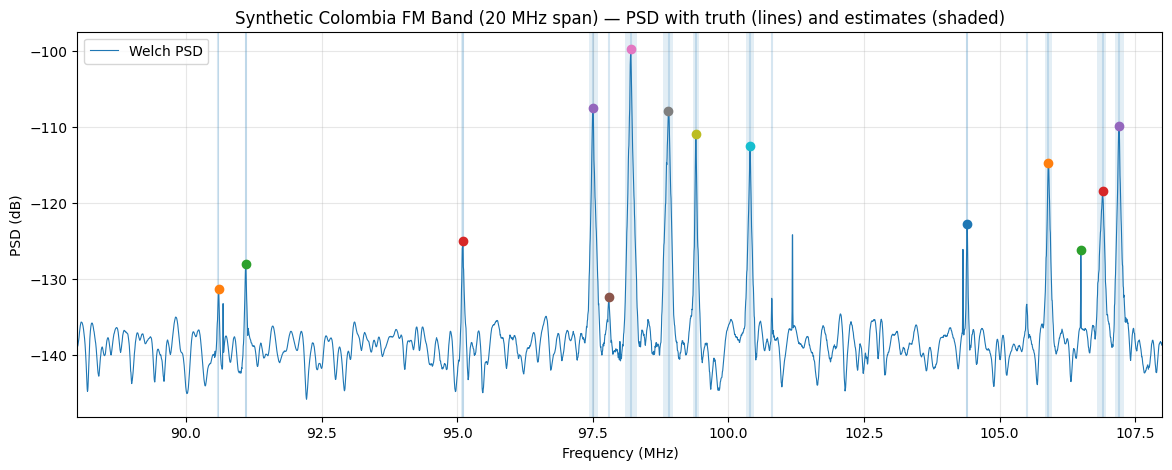

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from typing import Tuple, List, Dict

# ============================================================
# Helpers
# ============================================================

def db_to_linear_power(db: float) -> float:
    return 10 ** (db / 10.0)

def linear_power_to_db(p: np.ndarray, floor: float = 1e-30) -> np.ndarray:
    p = np.asarray(p)
    return 10.0 * np.log10(np.maximum(p, floor))

# -----------------------------
# Receiver/environment impairments
# -----------------------------

def add_colored_noise(iq, fs, tilt_db_across_band=8.0, ripple_db=2.0):
    """Frequency-shaped noise (tilt + ripple) applied in frequency domain."""
    n = iq.size
    X = np.fft.fft(iq)
    f = np.fft.fftfreq(n, d=1/fs)
    f_shift = np.fft.fftshift(f)

    tilt = (tilt_db_across_band) * (f_shift / (fs/2)) / 2.0
    ripple = ripple_db * np.sin(2*np.pi * (f_shift / (fs/6)))
    shape_db = tilt + ripple
    shape_lin = 10**(shape_db/20.0)

    shape_lin = np.fft.ifftshift(shape_lin)
    return np.fft.ifft(X * shape_lin)

def add_impulsive_noise(iq, rng, burst_prob=3e-5, burst_len_range=(20, 300), burst_rel_power_db=10):
    """
    Impulsive bursts. With 200k samples, this probability gives a few bursts per capture.
    """
    n = iq.size
    p_iq = np.mean(np.abs(iq)**2)
    p_burst = p_iq * (10**(burst_rel_power_db/10))
    burst_std = np.sqrt(p_burst/2)

    i = 0
    while i < n:
        if rng.random() < burst_prob:
            L = int(rng.integers(burst_len_range[0], burst_len_range[1] + 1))
            j = min(n, i + L)
            iq[i:j] += (rng.standard_normal(j-i) + 1j*rng.standard_normal(j-i)) * burst_std
            i = j
        else:
            i += 1
    return iq

def add_spurs(iq, fs, rng, num_spurs=4, spur_rel_amp_db=(-45, -30)):
    """Narrow spurs ("birdies")."""
    n = iq.size
    t = np.arange(n)/fs
    p = np.mean(np.abs(iq)**2)
    for _ in range(num_spurs):
        f0 = rng.uniform(-0.49*fs, 0.49*fs)
        amp_db = rng.uniform(*spur_rel_amp_db)
        amp = np.sqrt(p) * 10**(amp_db/20)
        phase = rng.uniform(0, 2*np.pi)
        iq += amp * np.exp(1j*(2*np.pi*f0*t + phase))
    return iq

def add_phase_jitter(iq, rng, jitter_std_rad=0.01):
    """Random phase walk (cheap phase-noise-ish)."""
    dphi = rng.standard_normal(iq.size) * jitter_std_rad
    phi = np.cumsum(dphi)
    return iq * np.exp(1j * phi)

def add_cfo(iq, fs, cfo_hz=80.0):
    """Constant frequency offset (CFO)."""
    n = iq.size
    t = np.arange(n) / fs
    return iq * np.exp(1j * 2*np.pi * cfo_hz * t)

def apply_multipath_channel(iq, fs, rng, max_delay_us=8.0, num_taps=6, decay_db_per_tap=4.0):
    """
    Frequency-selective multipath FIR channel -> jagged peaks.
    """
    max_delay_samp = int(max_delay_us * 1e-6 * fs)
    delays = np.sort(rng.integers(0, max(1, max_delay_samp + 1), size=num_taps))
    phases = rng.uniform(0, 2*np.pi, size=num_taps)
    mags_db = -decay_db_per_tap * np.arange(num_taps)
    mags = 10 ** (mags_db / 20.0)

    h = np.zeros(delays[-1] + 1, dtype=np.complex128)
    for d, mag, ph in zip(delays, mags, phases):
        h[d] += mag * np.exp(1j * ph)
    h /= np.sqrt(np.sum(np.abs(h)**2) + 1e-12)
    return signal.lfilter(h, [1.0], iq)

# -----------------------------
# Station baseband model
# -----------------------------

def make_audio_like_message(num_samples: int, fs: float, audio_bw_hz: float, rng: np.random.Generator) -> np.ndarray:
    """
    Audio-like low-pass message with adjustable BW.
    """
    raw = rng.standard_normal(num_samples)
    numtaps = 257
    cutoff = min(max(audio_bw_hz / (fs / 2.0), 1e-4), 0.95)
    h = signal.firwin(numtaps, cutoff=cutoff, window="hann")
    msg = signal.lfilter(h, [1.0], raw)

    msg = msg[numtaps:]
    if msg.size < num_samples:
        msg = np.pad(msg, (0, num_samples - msg.size))
    else:
        msg = msg[:num_samples]

    msg /= (np.max(np.abs(msg)) + 1e-12)
    return msg

def generate_wbfm_station(
    t: np.ndarray,
    fs: float,
    f_offset_hz: float,
    snr_db: float,
    noise_power_linear: float,
    rng: np.random.Generator,
    fm_dev_hz: float,
    audio_bw_hz: float,
    enable_splatter: bool = True,
) -> np.ndarray:
    """
    WBFM station with per-station deviation and audio BW.

    BW (Carson approximation) varies per station:
      BW_Carson ≈ 2*(fm_dev_hz + audio_bw_hz)
    """
    n = t.size
    msg = make_audio_like_message(n, fs, audio_bw_hz, rng)

    if enable_splatter:
        wobble = make_audio_like_message(n, fs, 2_000.0, rng)
        dev_t = fm_dev_hz * (1.0 + 0.04 * wobble)  # ±4%
    else:
        dev_t = fm_dev_hz

    phase_fm = 2.0 * np.pi * np.cumsum(dev_t * msg) / fs
    phase_car = 2.0 * np.pi * f_offset_hz * t
    s_unit = np.exp(1j * (phase_car + phase_fm))

    p_sig = noise_power_linear * (10.0 ** (snr_db / 10.0))
    amp = np.sqrt(p_sig)
    return amp * s_unit

# ============================================================
# Colombia FM raster and selection inside capture BW
# ============================================================

def colombia_fm_raster_hz() -> np.ndarray:
    """88.1 MHz to 107.9 MHz in 100 kHz steps."""
    return np.arange(88_100_000, 107_900_000 + 100_000, 100_000, dtype=np.int64)

def raster_within_capture(fc_global: float, fs: float) -> np.ndarray:
    """
    Only channels that are inside the captured instantaneous bandwidth:
      [fc - fs/2, fc + fs/2]
    """
    lo = fc_global - fs/2
    hi = fc_global + fs/2
    r = colombia_fm_raster_hz()
    return r[(r >= lo) & (r <= hi)]

def sample_station_params(rng: np.random.Generator, is_strong: bool):
    """
    Ensures power, bandwidth vary.
    """
    if is_strong:
        snr_db = float(rng.uniform(18.0, 34.0))
    else:
        snr_db = float(rng.uniform(0.0, 22.0))

    # bandwidth variation (Carson BW ~ 120–230 kHz)
    fm_dev_hz = float(rng.uniform(45_000, 100_000))
    audio_bw_hz = float(rng.uniform(9_000, 16_000))

    # small random power boost
    snr_db += float(rng.uniform(-2.5, 2.5))
    return snr_db, fm_dev_hz, audio_bw_hz

# ============================================================
# Simulator (200k samples spanning whole 20 MHz)
# ============================================================

def simulate_colombia_fm_iq(
    *,
    fs: float = 20_000_000,     # <-- 20 MHz instantaneous BW
    num_samples: int = 200_000, # <-- exactly 200k samples
    fc_global: float = 98_000_000,
    noise_floor_db: float = -88.0,
    num_stations: int = 15,
    min_sep_hz: float = 200_000,
    strong_station_fraction: float = 0.25,
    seed: int = 0,
    # impairments
    enable_multipath: bool = True,
    enable_receiver_junk: bool = True,
) -> Tuple[np.ndarray, List[dict], dict]:
    """
    200k complex IQ samples that span the full 20 MHz FM band when fs=20 MHz.

    Duration = num_samples/fs = 0.01 s (10 ms at 20 MS/s).
    """
    rng = np.random.default_rng(seed)
    t = np.arange(num_samples) / fs

    noise_power_linear = db_to_linear_power(noise_floor_db)
    noise_std = np.sqrt(noise_power_linear / 2.0)
    iq = (rng.standard_normal(num_samples) + 1j * rng.standard_normal(num_samples)) * noise_std

    # Limit channels to what is visible in this capture BW
    raster = raster_within_capture(fc_global, fs)
    if raster.size == 0:
        raise ValueError("No FM raster channels fall inside capture BW. Check fc_global/fs.")

    rng.shuffle(raster)

    chosen = []
    for f in raster:
        if len(chosen) >= num_stations:
            break
        if all(abs(int(f) - int(c)) >= int(min_sep_hz) for c in chosen):
            chosen.append(int(f))
    chosen = sorted(chosen)

    num_strong = int(np.round(strong_station_fraction * len(chosen)))
    strong_idx = set(rng.choice(len(chosen), size=max(0, num_strong), replace=False).tolist())

    meta: List[Dict[str, float]] = []
    for i, f_center in enumerate(chosen):
        is_strong = (i in strong_idx)
        snr_db, fm_dev_hz, audio_bw_hz = sample_station_params(rng, is_strong=is_strong)

        f_offset = float(f_center - fc_global)
        s = generate_wbfm_station(
            t=t,
            fs=fs,
            f_offset_hz=f_offset,
            snr_db=snr_db,
            noise_power_linear=noise_power_linear,
            rng=rng,
            fm_dev_hz=fm_dev_hz,
            audio_bw_hz=audio_bw_hz,
            enable_splatter=True,
        )
        iq += s

        bw_carson_hz = 2.0 * (fm_dev_hz + audio_bw_hz)
        meta.append(dict(
            f_center_hz=float(f_center),
            f_center_mhz=float(f_center / 1e6),
            snr_db=float(snr_db),
            fm_dev_hz=float(fm_dev_hz),
            audio_bw_hz=float(audio_bw_hz),
            bw_carson_hz=float(bw_carson_hz),
            station_type=("strong_local" if is_strong else "normal"),
        ))

    # Add impairments AFTER summing stations (receiver + channel)
    if enable_multipath:
        iq = apply_multipath_channel(iq, fs, rng, max_delay_us=8.0, num_taps=7, decay_db_per_tap=4.0)
        iq = add_cfo(iq, fs, cfo_hz=float(rng.uniform(-150.0, 150.0)))
        iq = add_phase_jitter(iq, rng, jitter_std_rad=0.01)

    if enable_receiver_junk:
        iq = add_colored_noise(iq, fs, tilt_db_across_band=10.0, ripple_db=2.5)
        iq = add_impulsive_noise(iq, rng, burst_prob=3e-5, burst_len_range=(20, 250), burst_rel_power_db=10)
        iq = add_spurs(iq, fs, rng, num_spurs=4, spur_rel_amp_db=(-45, -30))

    cfg = dict(
        fs=fs,
        num_samples=num_samples,
        duration_s=float(num_samples/fs),
        fc_global=fc_global,
        noise_floor_db=noise_floor_db,
        num_stations=len(chosen),
        min_sep_hz=min_sep_hz,
        seed=seed,
    )
    return iq, meta, cfg

# ============================================================
# PSD + feature extraction for calibration
# ============================================================

def welch_psd(iq: np.ndarray, fs: float, fc: float, nperseg: int = 4096, noverlap: int = 2048, window: str = "hann"):
    """
    Returns (f_hz, Pxx) with RF frequency axis.
    With 200k samples, nperseg=4096 gives enough segments while keeping detail.
    """
    f_rel, Pxx = signal.welch(
        iq, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nperseg,
        return_onesided=False, scaling="density", average="mean"
    )
    f_rel = np.fft.fftshift(f_rel)
    Pxx = np.fft.fftshift(Pxx)
    f_hz = fc + f_rel
    return f_hz, Pxx

def estimate_noise_floor_psd(Pxx: np.ndarray, q: float = 0.30) -> float:
    """Noise floor = median of the lowest-q fraction of bins."""
    thr = np.quantile(Pxx, q)
    quiet = Pxx[Pxx <= thr]
    return float(np.median(quiet)) if quiet.size else float(np.median(Pxx))

def feature_estimates_from_psd(
    f_hz: np.ndarray,
    Pxx: np.ndarray,
    *,
    k_sigma: float = 6.0,
    min_run_bins: int = 3,
) -> List[Dict[str, float]]:
    """
    CALIBRATION TARGETS (be crystal clear):

    For each detected emitter component:

    (A) Peak power (max power, "peak potency"):
        P_peak = max_{i in emitter} Pxx[i]              (linear PSD)
        f_peak = argmax_{i in emitter} Pxx[i]           (Hz)

    (B) Central frequency:
        f_centroid = sum_i f_i * Pex_i / sum_i Pex_i
        where Pex_i = max(Pxx[i] - P_floor, 0)

    (C) Bandwidth estimate:
        B_3dB = f_right - f_left where:
            - P_thr = P_peak / 2   (3 dB down in power)
            - expand left/right from the peak within the component while Pxx >= P_thr
    """
    f_hz = np.asarray(f_hz).reshape(-1)
    Pxx = np.asarray(Pxx).reshape(-1)

    P_floor = estimate_noise_floor_psd(Pxx, q=0.30)
    resid = Pxx - P_floor
    sigma = 1.4826 * np.median(np.abs(resid - np.median(resid))) + 1e-30
    mask = Pxx > (P_floor + k_sigma * sigma)

    # connected components
    comps = []
    i = 0
    while i < mask.size:
        if not mask[i]:
            i += 1
            continue
        j = i
        while j + 1 < mask.size and mask[j + 1]:
            j += 1
        if (j - i + 1) >= min_run_bins:
            comps.append((i, j))
        i = j + 1

    emitters = []
    for (i0, i1) in comps:
        idx = np.arange(i0, i1 + 1)

        i_pk = int(idx[np.argmax(Pxx[idx])])
        P_peak = float(Pxx[i_pk])
        f_peak = float(f_hz[i_pk])

        Pex = np.maximum(Pxx[idx] - P_floor, 0.0)
        denom = float(np.sum(Pex)) + 1e-30
        f_cent = float(np.sum(f_hz[idx] * Pex) / denom)

        P_thr = P_peak / 2.0
        left = i_pk
        while left - 1 >= i0 and Pxx[left - 1] >= P_thr:
            left -= 1
        right = i_pk
        while right + 1 <= i1 and Pxx[right + 1] >= P_thr:
            right += 1

        B_3dB = float(f_hz[right] - f_hz[left])

        emitters.append(dict(
            i_start=int(i0),
            i_stop=int(i1),
            f_start_hz=float(f_hz[i0]),
            f_stop_hz=float(f_hz[i1]),
            f_peak_hz=f_peak,
            P_peak=P_peak,
            f_centroid_hz=f_cent,
            B_3dB_hz=B_3dB,
            P_floor=P_floor,
        ))
    return emitters

# ============================================================
# Plot
# ============================================================

def plot_psd_with_truth_and_estimates(f_hz, Pxx, meta_truth, est_emitters):
    f_mhz = f_hz / 1e6
    P_db = linear_power_to_db(Pxx)

    plt.figure(figsize=(14, 5))
    plt.plot(f_mhz, P_db, lw=0.8, label="Welch PSD")
    plt.title("Synthetic Colombia FM Band (20 MHz span) — PSD with truth (lines) and estimates (shaded)")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("PSD (dB)")
    plt.grid(True, alpha=0.3)
    plt.xlim(88, 108)

    # truth centers
    for m in meta_truth:
        plt.axvline(m["f_center_mhz"], alpha=0.18)

    # estimated emitters
    for em in est_emitters:
        plt.axvspan(em["f_start_hz"]/1e6, em["f_stop_hz"]/1e6, alpha=0.12)
        fp = em["f_peak_hz"]/1e6
        i_pk = int(np.argmin(np.abs(f_hz - em["f_peak_hz"])))
        plt.plot([fp], [P_db[i_pk]], marker="o")

    plt.legend(loc="best")
    plt.show()

# ============================================================
# Example run
# ============================================================

iq, meta_truth, cfg = simulate_colombia_fm_iq(
    fs=20_000_000,        # 20 MHz instantaneous bandwidth
    num_samples=200_000,  # exactly 200k samples
    fc_global=98_000_000,
    noise_floor_db=-88.0,
    num_stations=15,
    min_sep_hz=250_000,
    strong_station_fraction=0.25,
    seed=5,
)

f_hz, Pxx = welch_psd(iq, fs=cfg["fs"], fc=cfg["fc_global"], nperseg=4096, noverlap=2048)
est_emitters = feature_estimates_from_psd(f_hz, Pxx, k_sigma=6.0, min_run_bins=3)

print("Config:", cfg)

print("\nTruth (first 5):")
for m in meta_truth[:5]:
    print({
        "f_center_MHz": m["f_center_mhz"],
        "snr_db": m["snr_db"],
        "bw_carson_kHz": m["bw_carson_hz"]/1e3,
        "station_type": m["station_type"],
    })

print("\nEstimates (first 5):")
for em in est_emitters[:5]:
    print({
        "f_peak_MHz": em["f_peak_hz"]/1e6,
        "f_centroid_MHz": em["f_centroid_hz"]/1e6,
        "B_3dB_kHz": em["B_3dB_hz"]/1e3,
        "P_peak_dB": float(linear_power_to_db(np.array([em["P_peak"]]))[0]),
    })

plot_psd_with_truth_and_estimates(f_hz, Pxx, meta_truth, est_emitters)


In [37]:
import numpy as np
from scipy import signal
from typing import List, Dict, Tuple
from dataclasses import dataclass

# ============================================================
# Global constants
# ============================================================

FS = 20_000_000
FC = 98_000_000
NUM_SAMPLES = 200_000

# Welch configs
WELCH_ONLINE = dict(nperseg=4096, noverlap=2048, window="hann")
WELCH_REF = dict(nperseg=8192, noverlap=4096, window="hann")

# ============================================================
# Utilities
# ============================================================

def db_to_lin(db): return 10**(db/10)

def lin_to_db(x, floor=1e-30):
    return 10*np.log10(np.maximum(x, floor))

def welch_psd(iq, fs, fc, *, nperseg, noverlap, window):
    f, P = signal.welch(
        iq, fs=fs, window=window,
        nperseg=nperseg, noverlap=noverlap,
        nfft=nperseg, return_onesided=False,
        scaling="density", average="mean"
    )
    f = np.fft.fftshift(f)
    P = np.fft.fftshift(P)
    return fc + f, P

def estimate_noise_floor(Pxx, q=0.3):
    thr = np.quantile(Pxx, q)
    return np.median(Pxx[Pxx <= thr])

# ============================================================
# FM signal model
# ============================================================

def make_audio(num, fs, bw, rng):
    raw = rng.standard_normal(num)
    h = signal.firwin(257, bw/(fs/2), window="hann")
    msg = signal.lfilter(h, [1], raw)
    msg = msg[257:]
    msg = np.pad(msg, (0, max(0, num-len(msg))))[:num]
    return msg / (np.max(np.abs(msg)) + 1e-12)

def gen_fm_station(t, fs, f_off, snr_db, noise_pwr, rng):
    dev = rng.uniform(45e3, 90e3)
    aud = rng.uniform(10e3, 16e3)
    msg = make_audio(len(t), fs, aud, rng)
    wobble = make_audio(len(t), fs, 2e3, rng)
    dev_t = dev*(1 + 0.04*wobble)
    phase = 2*np.pi*(f_off*t + np.cumsum(dev_t*msg)/fs)
    p_sig = noise_pwr * db_to_lin(snr_db)
    return np.sqrt(p_sig)*np.exp(1j*phase), dev, aud

# ============================================================
# Impairments
# ============================================================

def apply_impairments(iq, fs, rng, severity):
    if severity >= 1:
        iq *= np.exp(1j*np.cumsum(rng.normal(0,0.01,len(iq))))
    if severity >= 2:
        iq = signal.lfilter([1,0.4,0.2], [1], iq)
    if severity >= 3:
        iq += 0.02*(rng.standard_normal(len(iq))+1j*rng.standard_normal(len(iq)))
    return iq

# ============================================================
# Emitter reference extraction (labels)
# ============================================================

def extract_emitters_ref(f_hz, Pxx):
    floor = estimate_noise_floor(Pxx)
    mask = Pxx > floor + 6*np.std(Pxx[Pxx < floor])
    emitters = []

    i = 0
    while i < len(mask):
        if not mask[i]:
            i += 1; continue
        j = i
        while j+1 < len(mask) and mask[j+1]:
            j += 1
        idx = np.arange(i,j+1)
        i_pk = idx[np.argmax(Pxx[idx])]
        Ppk = Pxx[i_pk]
        Pex = np.maximum(Pxx[idx]-floor,0)
        f_cent = np.sum(f_hz[idx]*Pex)/np.sum(Pex)
        thr = Ppk/2
        l = i_pk
        while l-1>=i and Pxx[l-1]>=thr: l-=1
        r = i_pk
        while r+1<=j and Pxx[r+1]>=thr: r+=1
        emitters.append(dict(
            f_centroid_ref_hz=float(f_cent),
            f_center_ref_hz=float(f_hz[i_pk]),
            B_ref_hz=float(f_hz[r]-f_hz[l]),
            P_peak_ref=float(Ppk)
        ))
        i=j+1
    return emitters

# ============================================================
# One dataset sample
# ============================================================

def generate_sample(seed: int) -> Dict:
    rng = np.random.default_rng(seed)
    t = np.arange(NUM_SAMPLES)/FS

    noise_db = rng.uniform(-92,-85)
    noise_pwr = db_to_lin(noise_db)
    iq = (rng.standard_normal(NUM_SAMPLES)+1j*rng.standard_normal(NUM_SAMPLES))*np.sqrt(noise_pwr/2)

    num_stations = rng.integers(5,30)
    raster = np.arange(88.1e6,107.9e6,100e3)
    rng.shuffle(raster)

    meta = []
    stations = []
    for f in raster[:num_stations]:
        snr = rng.uniform(0,30)
        s, dev, aud = gen_fm_station(t, FS, f-FC, snr, noise_pwr, rng)
        iq += s
        meta.append(dict(
            snr_db=float(snr),
            bw_carson_hz=float(2*(dev+aud))
        ))
        stations.append(dict(
            f_center_hz=float(f),
            f_center_mhz=float(f / 1e6),
            bw_carson_hz=float(2 * (dev + aud)),
            snr_db=float(snr),
        ))

    iq = apply_impairments(iq, FS, rng, rng.integers(0,4))

    # Reference PSD (cleaner)
    f_ref, P_ref = welch_psd(iq, FS, FC, **WELCH_REF)
    emitters = extract_emitters_ref(f_ref, P_ref)

    return dict(
        iq=iq.astype(np.complex64),
        fs=FS,
        fc=FC,
        f_hz=f_ref,
        psd_ref=P_ref,
        emitters=emitters,
        stations=stations,
        scenario=dict(
            noise_floor_db=float(noise_db),
            num_stations=int(num_stations)
        )
    )

# ============================================================
# Dataset generator
# ============================================================

def generate_dataset(n_samples: int, seed0: int = 0):
    for k in range(n_samples):
        yield generate_sample(seed0 + k)

# Example:
# for sample in generate_dataset(3):
#     print(len(sample["emitters"]))


In [38]:
import json
from pathlib import Path
from typing import Dict, List, Any, Optional, Iterator

import numpy as np
import zarr
from numcodecs import Blosc


# -----------------------------
# Helpers for complex arrays in Zarr
# -----------------------------

def complex_to_view(x: np.ndarray) -> np.ndarray:
    """complex64 -> float32 view with last dimension=2 (real, imag)."""
    x = np.asarray(x)
    if x.dtype == np.complex64:
        return x.view(np.float32).reshape(x.shape + (2,))
    if x.dtype == np.complex128:
        return x.view(np.float64).reshape(x.shape + (2,))
    raise ValueError("Expected complex64 or complex128.")

def view_to_complex(v: np.ndarray, dtype=np.complex64) -> np.ndarray:
    """float view (...,2) -> complex."""
    v = np.asarray(v)
    if v.shape[-1] != 2:
        raise ValueError("Last dim must be 2 (real, imag).")
    if dtype == np.complex64:
        return v.astype(np.float32).reshape(v.shape[:-1] + (2,)).view(np.complex64).reshape(v.shape[:-1])
    if dtype == np.complex128:
        return v.astype(np.float64).reshape(v.shape[:-1] + (2,)).view(np.complex128).reshape(v.shape[:-1])
    raise ValueError("dtype must be complex64 or complex128.")


# -----------------------------
# Writer
# -----------------------------

def write_dataset_zarr(
    samples: List[Dict[str, Any]],
    out_path: str,
    *,
    overwrite: bool = True,
    compressor: Optional[Any] = None,
) -> str:
    """
    Write dataset to a Zarr directory store.

    Stores arrays:
      - iq_reim: (N, num_samples, 2) float32
      - f_hz:    (N, M) float64 (or float32)
      - psd_ref: (N, M) float32

    Stores per-sample JSON:
      - emitters.jsonl
      - scenario.jsonl
      - meta.json
    """
    out = Path(out_path)
    if overwrite and out.exists():
        # remove directory store
        import shutil
        shutil.rmtree(out)

    if compressor is None:
        compressor = Blosc(cname="zstd", clevel=5, shuffle=Blosc.BITSHUFFLE)

    N = len(samples)
    if N == 0:
        raise ValueError("No samples to write.")

    # Validate consistent lengths
    num_samples = int(np.asarray(samples[0]["iq"]).shape[0])
    M = int(np.asarray(samples[0]["f_hz"]).shape[0])

    for s in samples:
        if int(np.asarray(s["iq"]).shape[0]) != num_samples:
            raise ValueError("All iq arrays must have same length.")
        if int(np.asarray(s["f_hz"]).shape[0]) != M:
            raise ValueError("All f_hz arrays must have same length.")
        if int(np.asarray(s["psd_ref"]).shape[0]) != M:
            raise ValueError("All psd_ref arrays must have same length.")

    root = zarr.open_group(str(out), mode="w", zarr_format=2)

    # Chunking: one snapshot per chunk (easy)
    root.create_array(
        "iq_reim",
        shape=(N, num_samples, 2),
        chunks=(1, min(num_samples, 65536), 2),
        dtype=np.float32,
        compressor=compressor,
        overwrite=True,
    )

    root.create_array(
        "f_hz",
        shape=(N, M),
        chunks=(1, M),
        dtype=np.float64,
        compressor=compressor,
        overwrite=True,
    )
    root.create_array(
        "psd_ref",
        shape=(N, M),
        chunks=(1, M),
        dtype=np.float32,
        compressor=compressor,
        overwrite=True,
    )

    fs = np.zeros(N, dtype=np.float64)
    fc = np.zeros(N, dtype=np.float64)

    emitters_lines = []
    scenario_lines = []
    stations_lines = []

    for i, s in enumerate(samples):
        iq = np.asarray(s["iq"]).astype(np.complex64)
        root["iq_reim"][i] = complex_to_view(iq)

        f_hz = np.asarray(s["f_hz"]).astype(np.float64)
        P_ref = np.asarray(s["psd_ref"]).astype(np.float32)
        root["f_hz"][i] = f_hz
        root["psd_ref"][i] = P_ref

        fs[i] = float(s["fs"])
        fc[i] = float(s["fc"])

        emitters_lines.append(json.dumps(s.get("emitters", [])))
        scenario_lines.append(json.dumps(s.get("scenario", {})))
        stations_lines.append(json.dumps(s.get("stations", [])))


    root.create_array(
        "fs",
        shape=(N,),
        dtype=np.float64,
        overwrite=True,
    )
    root["fs"][:] = fs

    root.create_array(
        "fc",
        shape=(N,),
        dtype=np.float64,
        overwrite=True,
    )
    root["fc"][:] = fc

    # JSONL sidecars
    (out / "emitters.jsonl").write_text("\n".join(emitters_lines) + "\n", encoding="utf-8")
    (out / "scenario.jsonl").write_text("\n".join(scenario_lines) + "\n", encoding="utf-8")
    (out / "stations.jsonl").write_text(
    "\n".join(stations_lines) + "\n",
    encoding="utf-8"
)

    # Meta
    meta = dict(
        N=N,
        num_samples=num_samples,
        M=M,
        format="zarr+jsonl",
        iq_dtype="complex64 (stored as float32 re/im)",
    )
    (out / "meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

    return str(out)


# -----------------------------
# Reader
# -----------------------------

class ZarrDataset:
    def __init__(self, path: str):
        self.path = Path(path)
        self.root = zarr.open_group(str(self.path), mode="r")

        self.N = int(self.root["fs"].shape[0])
        self.num_samples = int(self.root["iq_reim"].shape[1])
        self.M = int(self.root["f_hz"].shape[1])

        # Load JSONL indices (small)
        self.emitters = [json.loads(line) for line in (self.path / "emitters.jsonl").read_text(encoding="utf-8").splitlines() if line.strip()]
        self.scenarios = [json.loads(line) for line in (self.path / "scenario.jsonl").read_text(encoding="utf-8").splitlines() if line.strip()]
        self.stations = [
            json.loads(line)
            for line in (self.path / "stations.jsonl")
                .read_text(encoding="utf-8")
                .splitlines()
            if line.strip()
        ]

        if len(self.emitters) != self.N or len(self.scenarios) != self.N:
            raise ValueError("JSONL rows do not match N.")

    def __len__(self): return self.N

    def get(self, i: int) -> Dict[str, Any]:
        iq = view_to_complex(self.root["iq_reim"][i], dtype=np.complex64)
        return dict(
            iq=iq,
            fs=float(self.root["fs"][i]),
            fc=float(self.root["fc"][i]),
            f_hz=np.asarray(self.root["f_hz"][i]),
            psd_ref=np.asarray(self.root["psd_ref"][i]),
            emitters=self.emitters[i],
            stations=self.stations[i],
            scenario=self.scenarios[i],
        )

    def __iter__(self) -> Iterator[Dict[str, Any]]:
        for i in range(self.N):
            yield self.get(i)

    def materialize_to_ram(self) -> List[Dict[str, Any]]:
        """Loads entire dataset into RAM."""
        return [self.get(i) for i in range(self.N)]


# -----------------------------
# Convenience wrapper: generate -> write
# -----------------------------

def generate_and_write_zarr(
    generator_fn,
    n_samples: int,
    out_path: str,
    seed0: int = 0,
) -> str:
    samples = [generator_fn(seed0 + k) for k in range(n_samples)]
    return write_dataset_zarr(samples, out_path, overwrite=True)


In [47]:
# assuming you already have generate_sample(seed) from earlier
from pathlib import Path

out_dir = "fm_dataset_200k.zarr"
path = generate_and_write_zarr(generate_sample, n_samples=500, out_path=out_dir, seed0=0)
print("Wrote dataset:", path)


Wrote dataset: fm_dataset_200k.zarr


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Load dataset
ds = ZarrDataset("fm_dataset_200k.zarr")

print("Dataset size:", len(ds))
print("IQ length:", ds.num_samples)
print("PSD bins:", ds.M)


Dataset size: 500
IQ length: 200000
PSD bins: 8192


In [49]:
def compute_online_psd(iq, fs, fc, nperseg=4096, noverlap=2048):
    f_rel, Pxx = signal.welch(
        iq,
        fs=fs,
        window="hann",
        nperseg=nperseg,
        noverlap=noverlap,
        nfft=nperseg,
        return_onesided=False,
        scaling="density",
        average="mean",
    )
    f = np.fft.fftshift(f_rel)
    P = np.fft.fftshift(Pxx)
    return fc + f, P

In [50]:
def plot_sample(sample, show_ref=True, xlim_mhz=(88, 108)):
    iq = sample["iq"]
    fs = sample["fs"]
    fc = sample["fc"]
    meta = sample["emitters"]

    # Online PSD
    f_on, P_on = compute_online_psd(iq, fs, fc)
    P_on_db = 10 * np.log10(P_on + 1e-30)

    # Reference PSD
    f_ref = sample["f_hz"]
    P_ref = sample["psd_ref"]
    P_ref_db = 10 * np.log10(P_ref + 1e-30)

    plt.figure(figsize=(14, 5))

    plt.plot(f_on / 1e6, P_on_db, lw=0.8, label="Online PSD", alpha=0.9)

    if show_ref:
        plt.plot(f_ref / 1e6, P_ref_db, lw=1.2, alpha=0.7, label="Reference PSD")

    # Overlay emitters
    for e in meta:
        fc_ref = e["f_center_ref_hz"] / 1e6
        fcent = e["f_centroid_ref_hz"] / 1e6
        bw = e["B_ref_hz"] / 1e6

        plt.axvline(fc_ref, color="r", alpha=0.25)
        plt.axvline(fcent, color="k", linestyle="--", alpha=0.25)
        plt.axvspan(
            fcent - bw / 2,
            fcent + bw / 2,
            color="orange",
            alpha=0.15,
        )

    plt.title(
        f"PSD + Ground Truth Emitters | {len(meta)} stations\n"
        f"Noise floor: {sample['scenario']['noise_floor_db']:.1f} dB"
    )
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("PSD (dB)")
    plt.xlim(*xlim_mhz)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()



--- Sample 425 ---
Scenario: {'noise_floor_db': -91.37843136197594, 'num_stations': 19}
Num emitters: 69


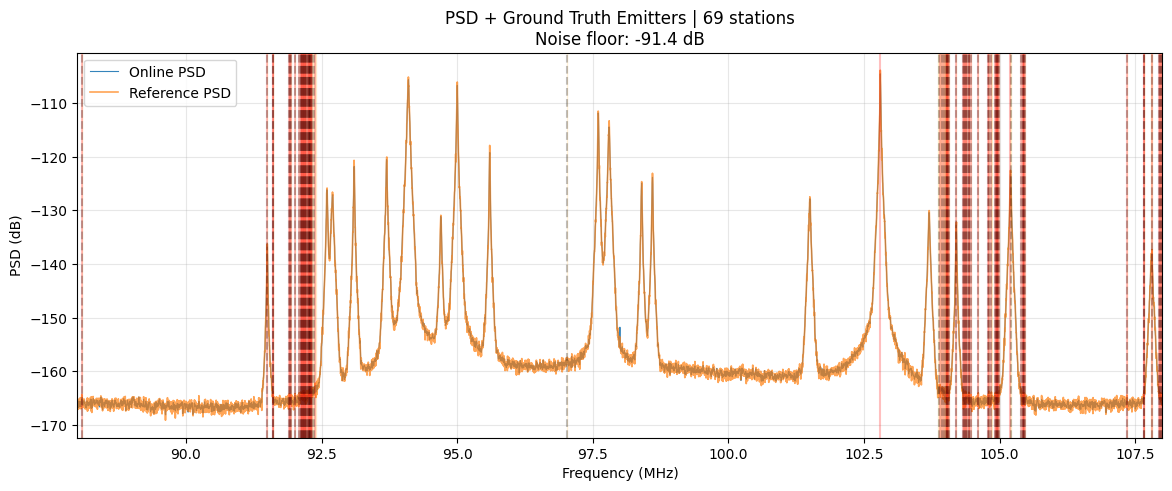


--- Sample 318 ---
Scenario: {'noise_floor_db': -85.28766915741808, 'num_stations': 24}
Num emitters: 102


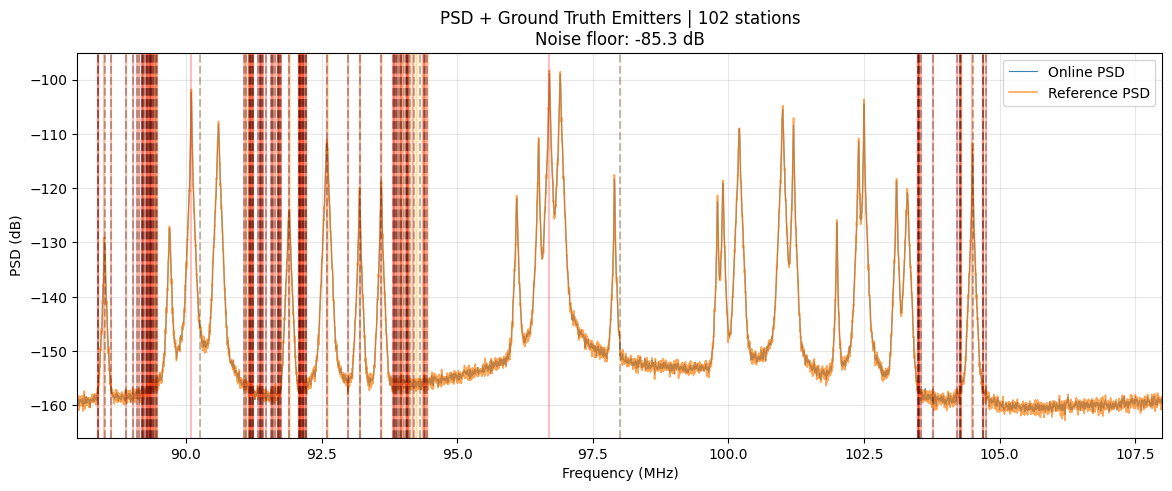


--- Sample 255 ---
Scenario: {'noise_floor_db': -86.34007477754902, 'num_stations': 10}
Num emitters: 589


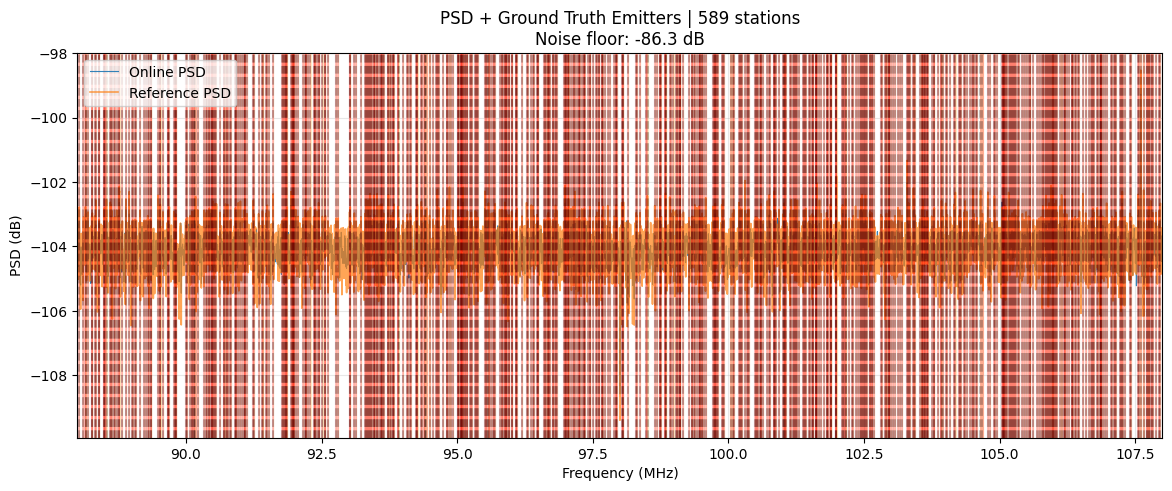

In [51]:
rng = np.random.default_rng(0)

for _ in range(3):
    i = rng.integers(0, len(ds))
    sample = ds.get(i)

    print(f"\n--- Sample {i} ---")
    print("Scenario:", sample["scenario"])
    print("Num emitters:", len(sample["emitters"]))

    plot_sample(sample)


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_sample_stations_only(
    sample,
    *,
    nperseg=4096,
    noverlap=2048,
    xlim_mhz=(88, 108),
):
    """
    Plot PSD and overlay TRUE STATION parameters only.
    """
    iq = sample["iq"]
    fs = sample["fs"]
    fc = sample["fc"]
    stations = sample.get("stations", None)

    if stations is None:
        raise ValueError("Sample does not contain 'stations' metadata.")

    # Compute PSD (online-like)
    f_rel, Pxx = signal.welch(
        iq,
        fs=fs,
        window="hann",
        nperseg=nperseg,
        noverlap=noverlap,
        nfft=nperseg,
        return_onesided=False,
        scaling="density",
        average="mean",
    )
    f = np.fft.fftshift(f_rel)
    P = np.fft.fftshift(Pxx)
    f_mhz = (f + fc) / 1e6
    P_db = 10 * np.log10(P + 1e-30)

    # Plot PSD
    plt.figure(figsize=(14, 5))
    plt.plot(f_mhz, P_db, lw=0.8, label="PSD")

    # Overlay stations
    for s in stations:
        f0 = s["f_center_hz"] / 1e6
        bw = s["bw_carson_hz"] / 1e6

        # Center frequency
        plt.axvline(f0, color="red", alpha=0.3)

        # Nominal bandwidth (Carson)
        plt.axvspan(
            f0 - bw / 2,
            f0 + bw / 2,
            color="red",
            alpha=0.12,
        )

    plt.title(
        f"PSD + TRUE Stations ({len(stations)} total)\n"
        f"Noise floor: {sample['scenario']['noise_floor_db']:.1f} dB"
    )
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("PSD (dB)")
    plt.xlim(*xlim_mhz)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()



--- Sample 425 ---
Stations: 19
Emitters: 69


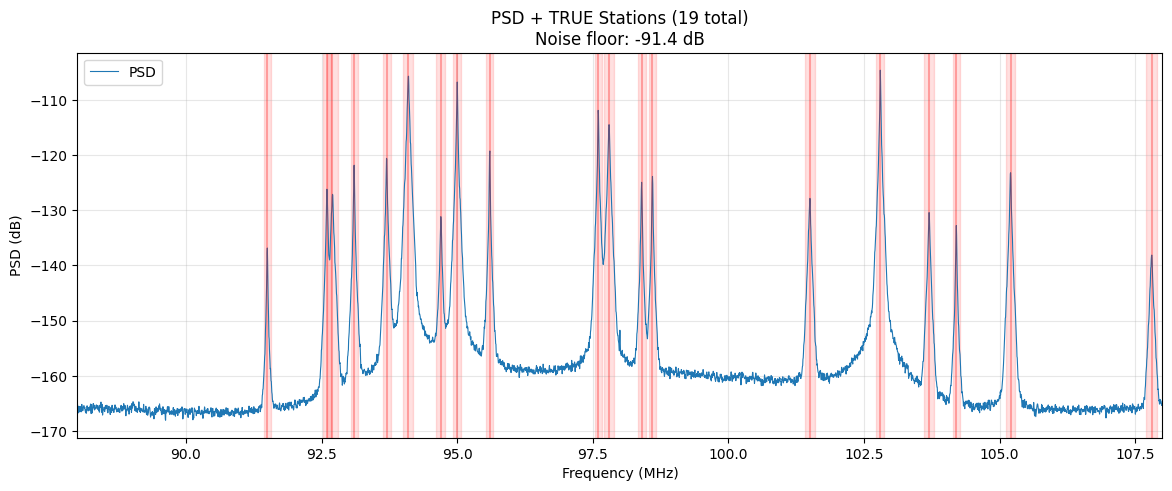


--- Sample 318 ---
Stations: 24
Emitters: 102


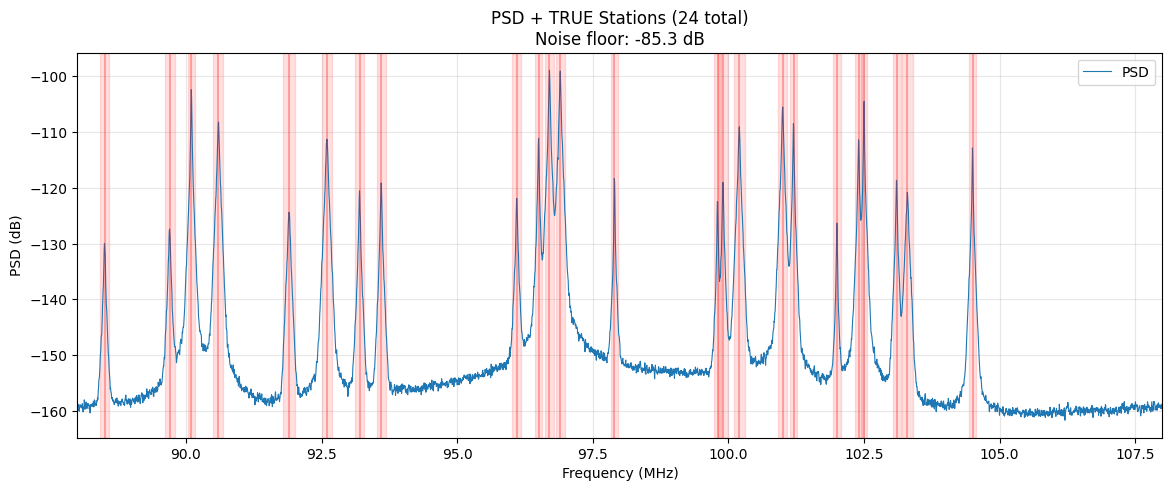


--- Sample 255 ---
Stations: 10
Emitters: 589


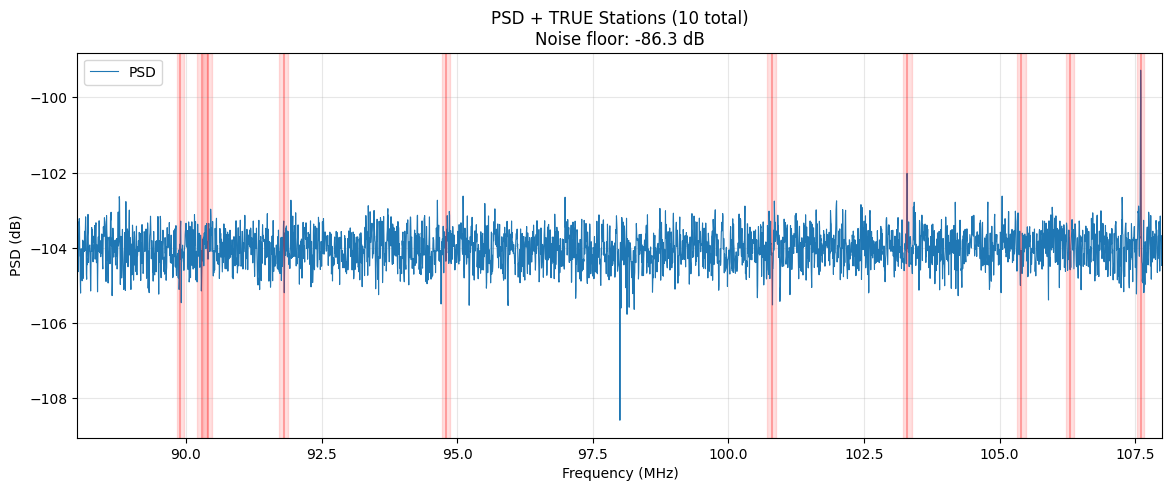


--- Sample 134 ---
Stations: 19
Emitters: 660


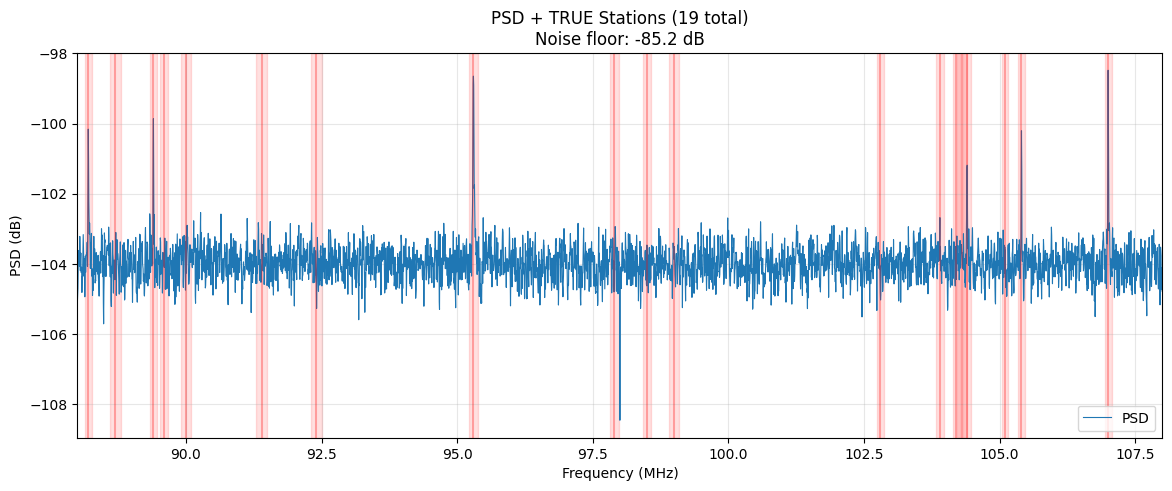

In [53]:
rng = np.random.default_rng(0)

for _ in range(4):
    i = rng.integers(0, len(ds))
    sample = ds.get(i)

    print(f"\n--- Sample {i} ---")
    print("Stations:", len(sample["stations"]))
    print("Emitters:", len(sample["emitters"]))

    plot_sample_stations_only(sample)


In [25]:
ds.get(0).keys()

dict_keys(['iq', 'fs', 'fc', 'f_hz', 'psd_ref', 'emitters', 'scenario'])

In [26]:
ds.get(0)["scenario"]

{'noise_floor_db': -87.54126818874983, 'num_stations': 16}